In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd

In [3]:
from birds_utils import DataGenerator, DataGeneratorV2, get_class_audio_files_npy

# dataset_folder_train = './dataset/train/'
# dataset_folder_val = './dataset/val/'
# dgen_train = DataGenerator(dataset_folder_train, batch_size=128)
# dgen_val = DataGenerator(dataset_folder_val, batch_size=128)

# train_files = np.load('train_files.npy')
# val_files = np.load('val_files.npy')
# train_labels = np.load('train_labels.npy')
# val_labels = np.load('val_labels.npy')
TARGET_FOLDER = './dataset/npy_22050/'

class_audiofiles, train_files, val_files, train_labels, val_labels = get_class_audio_files_npy(TARGET_FOLDER)

0.21361009081555837
0.20091738827949074
0.2179879152296707


In [46]:
min_std = 0.5
N = 5
dgen_train = DataGeneratorV2(list(train_files)*N, list(train_labels)*N, min_std=min_std, batch_size=128)
dgen_val = DataGeneratorV2(list(val_files)*N, list(val_labels)*N, min_std=min_std, batch_size=128)

{'aldfly': 0, 'amecro': 1, 'amegfi': 2}
{'aldfly': 0, 'amecro': 1, 'amegfi': 2}


In [47]:
# dgen_val.indexes

In [48]:
# full = np.load(train_files[0])
# plt.figure(figsize=(30,4))
# plt.plot(full)
# x, fr, to = dgen_train.sample_audio_clip(train_files[0])
# trunc = np.zeros(len(full))
# trunc[fr: to] = x
# plt.plot(trunc)
# plt.show()
# plt.plot(x)

In [49]:
len(dgen_val)/(len(dgen_train) + len(dgen_val))

0.16666666666666666

In [56]:
%%time
for x, c in dgen_train:
    print(x.shape, c.shape)
    
# for x, c in dgen_val:
#     print(x.shape, c.shape)

(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(128, 110250, 1) (128, 3)
(88, 110250, 1) (88, 3)
CPU times: user 796 ms, sys: 2.89 s, total: 3.69 s
Wall time: 3.68 s


In [8]:
# c

In [9]:
# for i in range(32):
#     print(x[i,:,0].std())

In [12]:
# plt.plot(x[0,:,0])
# ipd.Audio(x[0,:,0], rate=22050)
# x[0,:,0].std()

In [14]:
# len(dgen_train), len(dgen_val)

In [14]:
# del X, y

In [52]:
def get_fourier_weights(window_size):
    frec = np.linspace(-window_size//2, window_size//2-1, window_size)
    time = np.linspace(0, window_size-1, window_size)
    hanning_window = np.hanning(window_size)

    filters_cos = []
    filters_sin = []
    for i in range(window_size//2):
        filters_cos.append(np.cos(2*np.pi*frec[i]*time/window_size))
        filters_sin.append(np.sin(2*np.pi*frec[i]*time/window_size))
    filters_cos = np.array(filters_cos)[::-1]*hanning_window
    filters_sin = np.array(filters_sin)[::-1]*hanning_window
    return filters_cos, filters_sin

def set_cnn_weights(model, filters_cos, filters_sin, cos_layer='cos', sin_layer='sin'):
    weights_cos = model.get_layer(cos_layer).get_weights()
    weights_sin = model.get_layer(sin_layer).get_weights()
    weights_cos[0] = np.array(filters_cos).T.reshape(kernel_size, 1, filters)
    weights_sin[0] = np.array(filters_sin).T.reshape(kernel_size, 1, filters)
    model.get_layer(cos_layer).set_weights(weights_cos)
    model.get_layer(sin_layer).set_weights(weights_sin)

In [53]:
from tensorflow.keras.layers import Dense, Conv1D, Input, MaxPool1D, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [54]:
#model = Sequential()
window_size = 1024
kernel_size = window_size
stride = kernel_size//4
filters = kernel_size//2
inp = Input(shape=(None,1))
cos_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'cos')(inp)
sin_out = Conv1D(filters, kernel_size, stride, padding='same', name = 'sin')(inp)
fourier_out = K.log(K.square(cos_out) + K.square(sin_out))
# fourier_out = Activation('relu')(cos_out) + Activation('relu')(sin_out)
gap_out = GlobalAveragePooling1D()(fourier_out)
out = Dense(3, activation='softmax')(gap_out)

#  model = Model(inp, [fourier_out, out])
model = Model(inp, out)

model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
cos (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
sin (Conv1D)                    (None, None, 512)    524800      input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Square (TensorFlowO [(None, None, 512)]  0           cos[0][0]                        
______________________________________________________________________________________________

In [55]:
filters_cos, filters_sin = get_fourier_weights(window_size)
set_cnn_weights(model, filters_cos, filters_sin)

In [19]:
# model.get_layer('cos').trainable = False
# model.get_layer('sin').trainable = False

In [58]:
cbs = [
    callbacks.ModelCheckpoint('weights_1024.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True),
    # callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=1e-5)
] 


In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(dgen_train, epochs=20, validation_data=dgen_val, callbacks=cbs, use_multiprocessing=True, workers=8)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.4732 - accuracy: 0.4613WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_accuracy improved from -inf to 0.53333, saving model to weights_1024.hdf5
10/10 [==============================] - 57s 6s/step - loss: 1.4732 - accuracy: 0.4613 - val_loss: 1.0654 - val_accuracy: 0.5333
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.5677

Process Keras_worker_ForkPoolWorker-41:
Process Keras_worker_ForkPoolWorker-43:
Process Keras_worker_ForkPoolWorker-44:
Process Keras_worker_ForkPoolWorker-48:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/usuario/anaconda3/envs/tensorflow2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/usuario/anaconda3/envs/tensorflow2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/usuario/anaconda3/envs/tensorflow2/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


In [ ]:
# time = np.linspace(0, window_size-1, window_size)
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_cos[i])
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.plot(time/sr, filters_sin[i])

In [ ]:
# filters_cos, filters_sin = get_fourier_weights(window_size)
# set_cnn_weights(model, filters_cos, filters_sin)

In [19]:
model.evaluate(dgen_val)

92/92 [==============================] - 127s 1s/step - loss: 0.5599 - accuracy: 0.8554


[0.5599498748779297, 0.8554206490516663]

In [20]:
model.load_weights('weights_1024.hdf5')
model.evaluate(dgen_val)

92/92 [==============================] - 9s 97ms/step - loss: 0.5534 - accuracy: 0.8606


[0.5534175038337708, 0.8606361150741577]

In [21]:
# 0.9569892287254333 window size 512

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

NameError: name 'history' is not defined

In [24]:
weights_cos = model.get_layer('cos').get_weights()[0].T.reshape(filters_cos.shape)
weights_sin = model.get_layer('sin').get_weights()[0].T.reshape(filters_sin.shape)

In [25]:
most_diff_indexes = np.argsort((weights_cos - filters_cos).var(axis=1))[::-1]

In [26]:
most_diff_indexes[:20]

array([ 68, 269, 467, 160, 380, 425, 365, 409, 416, 389, 259, 433, 408,
       414, 403, 198, 445, 442, 417, 345])

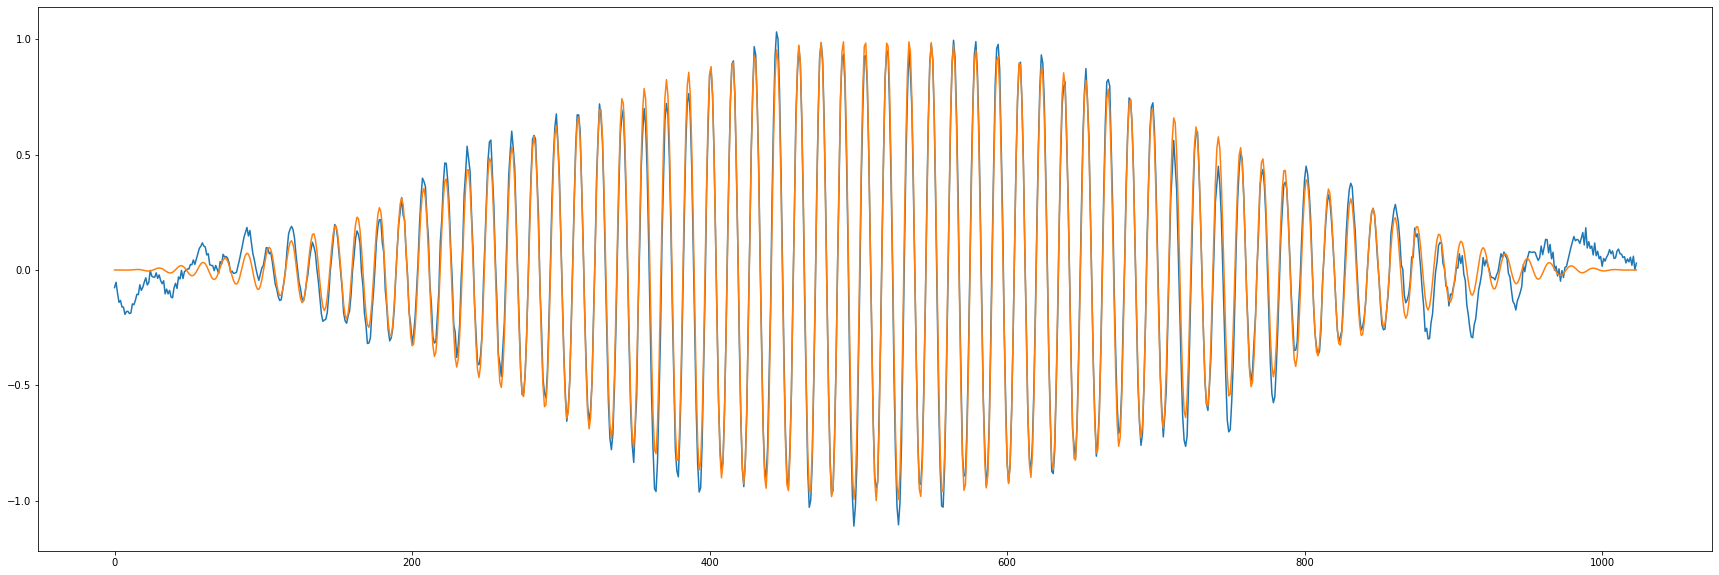

In [29]:
idx = 68
plt.figure(figsize=(30,10))
plt.plot(weights_cos[idx])
plt.plot(filters_cos[idx])

In [48]:
# x, sr, duration = get_train_clip(train[train['ebird_code']=='ameavo'].iloc[0])
# print(duration)